<a href="https://colab.research.google.com/github/Ohalu909/AI-for-gamedev/blob/main/AIG_assignment_3_HGBR_physio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NURSYAZWANI BINTI MOHAMMAD 17206746

# AFIFAH BINTI ABDUL HALIM 17203106

In [ ]:
!pip install neurokit2 shap

In [ ]:
# load Python packages
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load Maze Ball dataset
mb_data = pd.read_json("/content/mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [ ]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [ ]:
# let's take the first player as an example
player_no = 0
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(np.shape(p_games[player_no])))

Player information: 
{'player_id': 1, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 5}
Number of sets of games played by this player is (4,)


In [ ]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [ ]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [ ]:
# in each set, players played Game A and Game B
# for subjective ratings, players were asked whether they felt more "Anxiety" or "Challenge" etc when playing Game A or Game B
print(p_games_pref['anxiety'])
print(p_games_pref['challenge'])
print(p_games_pref['excitement'])
print(p_games_pref['boredom'])
print(p_games_pref['frustration'])
print(p_games_pref['relaxation'])
print(p_games_pref['fun'])

B
B
B
A
Both equally
Both equally
B


In [ ]:
print("Physiological signals include ", p_games_data['A'][game_set_no]['physio'].keys())

Physiological signals include  dict_keys(['SC', 'BVP', 'time'])


In [ ]:
print("Gameplay include ", p_games_data['A'][game_set_no]['gameplay'].keys())

Gameplay include  dict_keys(['event', 'score', 'distance2pellets_euclidean', 'time', 'distance2enemies_path', 'distance2camera', 'distance2enemies_euclidean', 'mapdiscovered', 'tilevisits', 'distance2pellets_path'])


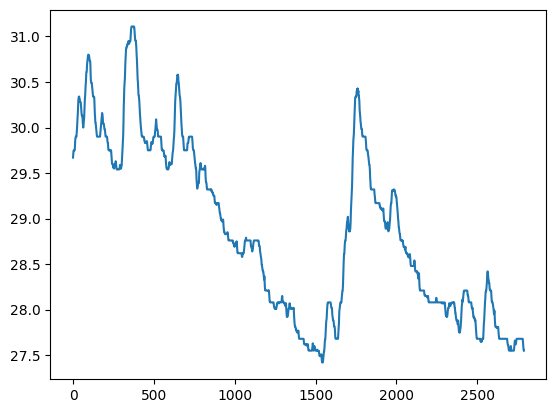

In [ ]:
sample_signal = p_games_data['A'][game_set_no]['physio']['SC']
plt.plot(sample_signal)

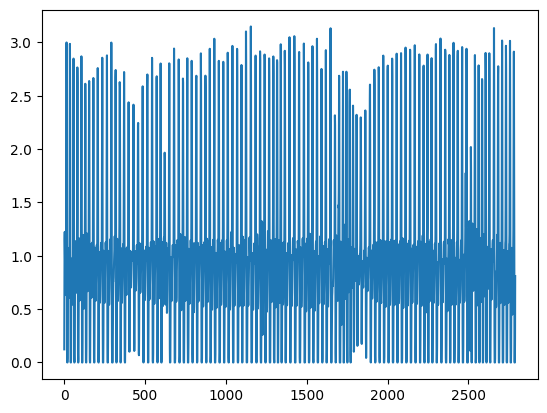

In [ ]:
sample_signal = p_games_data['A'][game_set_no]['physio']['BVP']
plt.plot(sample_signal)

In [ ]:
# time stamps for data recording; one sample measured every 0.03 seconds
# print(p_games_data['A'][game_set_no]['physio']['time'])
print("Sampling rate is {:.1f} Hz".format(1./p_games_data['A'][game_set_no]['physio']['time'][1]))

Sampling rate is 31.3 Hz


In [ ]:
# perform feature extraction on the SC signal and the BVP signal before classification
# extract features
df, info = nk.eda_process(p_games_data['A'][game_set_no]['physio']['SC'], sampling_rate=31)

features_sc = {
    'scr_amplitude_mean': np.nanmean(info['SCR_Amplitude']),
    'scr_amplitude_std': np.nanstd(info['SCR_Amplitude']),
    'scr_risetime_mean': np.nanmean(info['SCR_RiseTime']),
    'scr_risetime_std': np.nanstd(info['SCR_RiseTime']),
    'scr_recoverytime_mean': np.nanmean(info['SCR_RecoveryTime']),
    'scr_recoverytime_std': np.nanstd(info['SCR_RecoveryTime']),
}

In [ ]:
print(features_sc)

{'scr_amplitude_mean': 0.35852992511176907, 'scr_amplitude_std': 0.3129499803049444, 'scr_risetime_mean': 0.8595825426944973, 'scr_risetime_std': 0.40622281691352335, 'scr_recoverytime_mean': 0.4919354838709677, 'scr_recoverytime_std': 0.36020502313108543}


In [ ]:
df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
features_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
print(features_bvp)

   PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]


In [ ]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])

    feature_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ]

    return features_sc, feature_sc_names

def extract_bvp(signal):
    df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    feature_bvp_names = list(feature_bvp)

    print("Features bvp: ", feature_bvp)

    return feature_bvp.to_numpy()[0], feature_bvp_names

In [ ]:
# Example of dataset collection to model emotion (i.e. "Anxiety", "Challenge")
# for each pairwise comparison, create two data points

In [ ]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
#     'features_gameplay': [],
#     'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

for a in tqdm(range(36)): # player number
    player_demographics = p_demo[a] # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)): # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        # # Game A physiological features
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
        features_sc_a, features_sc_names = extract_sc(game_a['physio']['SC'])
        features_bvp_a, features_bvp_names = extract_bvp(game_a['physio']['BVP'])

        # Game B physiological features
        features_sc_b, _ = extract_sc(game_b['physio']['SC'])
        features_bvp_b, _ = extract_bvp(game_b['physio']['BVP'])

        # which affective data to collect?
        c = "boredom"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_a]
        alldata['features_bvp'] += [features_bvp_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_b]
        alldata['features_bvp'] += [features_bvp_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A": # if game A is more preferred than game B
            alldata['class'] += [1] # class label for Game A
            alldata['class'] += [0] # class label for Game B

        elif game_pref[c] == "B": # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]

  0%|          | 0/36 [00:00<?, ?it/s]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

  3%|▎         | 1/36 [00:01<01:03,  1.81s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

  6%|▌         | 2/36 [00:03<00:54,  1.62s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

  8%|▊         | 3/36 [00:05<00:55,  1.67s/it]

   PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.76873

 11%|█         | 4/36 [00:06<00:50,  1.57s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 14%|█▍        | 5/36 [00:09<01:08,  2.21s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 17%|█▋        | 6/36 [00:14<01:30,  3.01s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 19%|█▉        | 7/36 [00:17<01:26,  2.98s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 22%|██▏       | 8/36 [00:21<01:30,  3.23s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 25%|██▌       | 9/36 [00:26<01:42,  3.78s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 28%|██▊       | 10/36 [00:29<01:33,  3.59s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 31%|███       | 11/36 [00:32<01:27,  3.51s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 33%|███▎      | 12/36 [00:36<01:29,  3.73s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 36%|███▌      | 13/36 [00:42<01:37,  4.26s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 39%|███▉      | 14/36 [00:45<01:24,  3.83s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 42%|████▏     | 15/36 [00:48<01:19,  3.77s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 44%|████▍     | 16/36 [00:52<01:14,  3.71s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 47%|████▋     | 17/36 [00:56<01:12,  3.82s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 50%|█████     | 18/36 [00:59<01:06,  3.71s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 53%|█████▎    | 19/36 [01:02<00:58,  3.43s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 56%|█████▌    | 20/36 [01:06<00:56,  3.52s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 58%|█████▊    | 21/36 [01:10<00:54,  3.62s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 61%|██████    | 22/36 [01:11<00:42,  3.01s/it]


Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     

 64%|██████▍   | 23/36 [01:13<00:32,  2.53s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 67%|██████▋   | 24/36 [01:14<00:26,  2.20s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 69%|██████▉   | 25/36 [01:15<00:21,  1.96s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 72%|███████▏  | 26/36 [01:17<00:17,  1.79s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 75%|███████▌  | 27/36 [01:18<00:15,  1.71s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 78%|███████▊  | 28/36 [01:20<00:14,  1.81s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 81%|████████  | 29/36 [01:22<00:13,  1.88s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 83%|████████▎ | 30/36 [01:24<00:10,  1.74s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 86%|████████▌ | 31/36 [01:25<00:08,  1.66s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 89%|████████▉ | 32/36 [01:27<00:07,  1.76s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 92%|█████████▏| 33/36 [01:31<00:07,  2.38s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 94%|█████████▍| 34/36 [01:35<00:05,  2.94s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

 97%|█████████▋| 35/36 [01:39<00:03,  3.18s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]
Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0

100%|██████████| 36/36 [01:43<00:00,  2.87s/it]

Features bvp:     PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]


In [ ]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
                alldata['player_playgames'][i],
                alldata['player_playfrequency'][i],
                alldata['game_variant'][i]
            ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_sc_names
feature_names += features_bvp_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Pairwise Data Generation
pairwise_X = []
pairwise_Y = []

for i in range(len(Y)):
    for j in range(i + 1, len(Y)):
        pair = X[i] - X[j]
        pairwise_X.append(pair)
        pairwise_Y.append(Y[i] - Y[j])

pairwise_X = np.array(pairwise_X)
pairwise_Y = np.array(pairwise_Y)

# Feature Scaling (if needed)
scaler = StandardScaler()
pairwise_X_scaled = scaler.fit_transform(pairwise_X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(pairwise_X_scaled, pairwise_Y, test_size=0.2, random_state=42)

# Regression Model Training
regression_model = HistGradientBoostingRegressor()
regression_model.fit(X_train, y_train)

# Predictions
y_pred = regression_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.3390741330349132


In [ ]:
feature_names

['player_age',
 'player_gender',
 'player_playgames',
 'player_playfrequency',
 'game_variant',
 'SCR_Amplitude_mean',
 'SCR_Amplitude_std',
 'SCR_RiseTime_mean',
 'SCR_RiseTime_std',
 'SCR_RecoveryTime_mean',
 'SCR_RecoveryTime_std',
 'PPG_Rate_Mean',
 'HRV_MeanNN',
 'HRV_SDNN',
 'HRV_SDANN1',
 'HRV_SDNNI1',
 'HRV_SDANN2',
 'HRV_SDNNI2',
 'HRV_SDANN5',
 'HRV_SDNNI5',
 'HRV_RMSSD',
 'HRV_SDSD',
 'HRV_CVNN',
 'HRV_CVSD',
 'HRV_MedianNN',
 'HRV_MadNN',
 'HRV_MCVNN',
 'HRV_IQRNN',
 'HRV_SDRMSSD',
 'HRV_Prc20NN',
 'HRV_Prc80NN',
 'HRV_pNN50',
 'HRV_pNN20',
 'HRV_MinNN',
 'HRV_MaxNN',
 'HRV_HTI',
 'HRV_TINN',
 'HRV_ULF',
 'HRV_VLF',
 'HRV_LF',
 'HRV_HF',
 'HRV_VHF',
 'HRV_TP',
 'HRV_LFHF',
 'HRV_LFn',
 'HRV_HFn',
 'HRV_LnHF',
 'HRV_SD1',
 'HRV_SD2',
 'HRV_SD1SD2',
 'HRV_S',
 'HRV_CSI',
 'HRV_CVI',
 'HRV_CSI_Modified',
 'HRV_PIP',
 'HRV_IALS',
 'HRV_PSS',
 'HRV_PAS',
 'HRV_GI',
 'HRV_SI',
 'HRV_AI',
 'HRV_PI',
 'HRV_C1d',
 'HRV_C1a',
 'HRV_SD1d',
 'HRV_SD1a',
 'HRV_C2d',
 'HRV_C2a',
 'HRV_SD

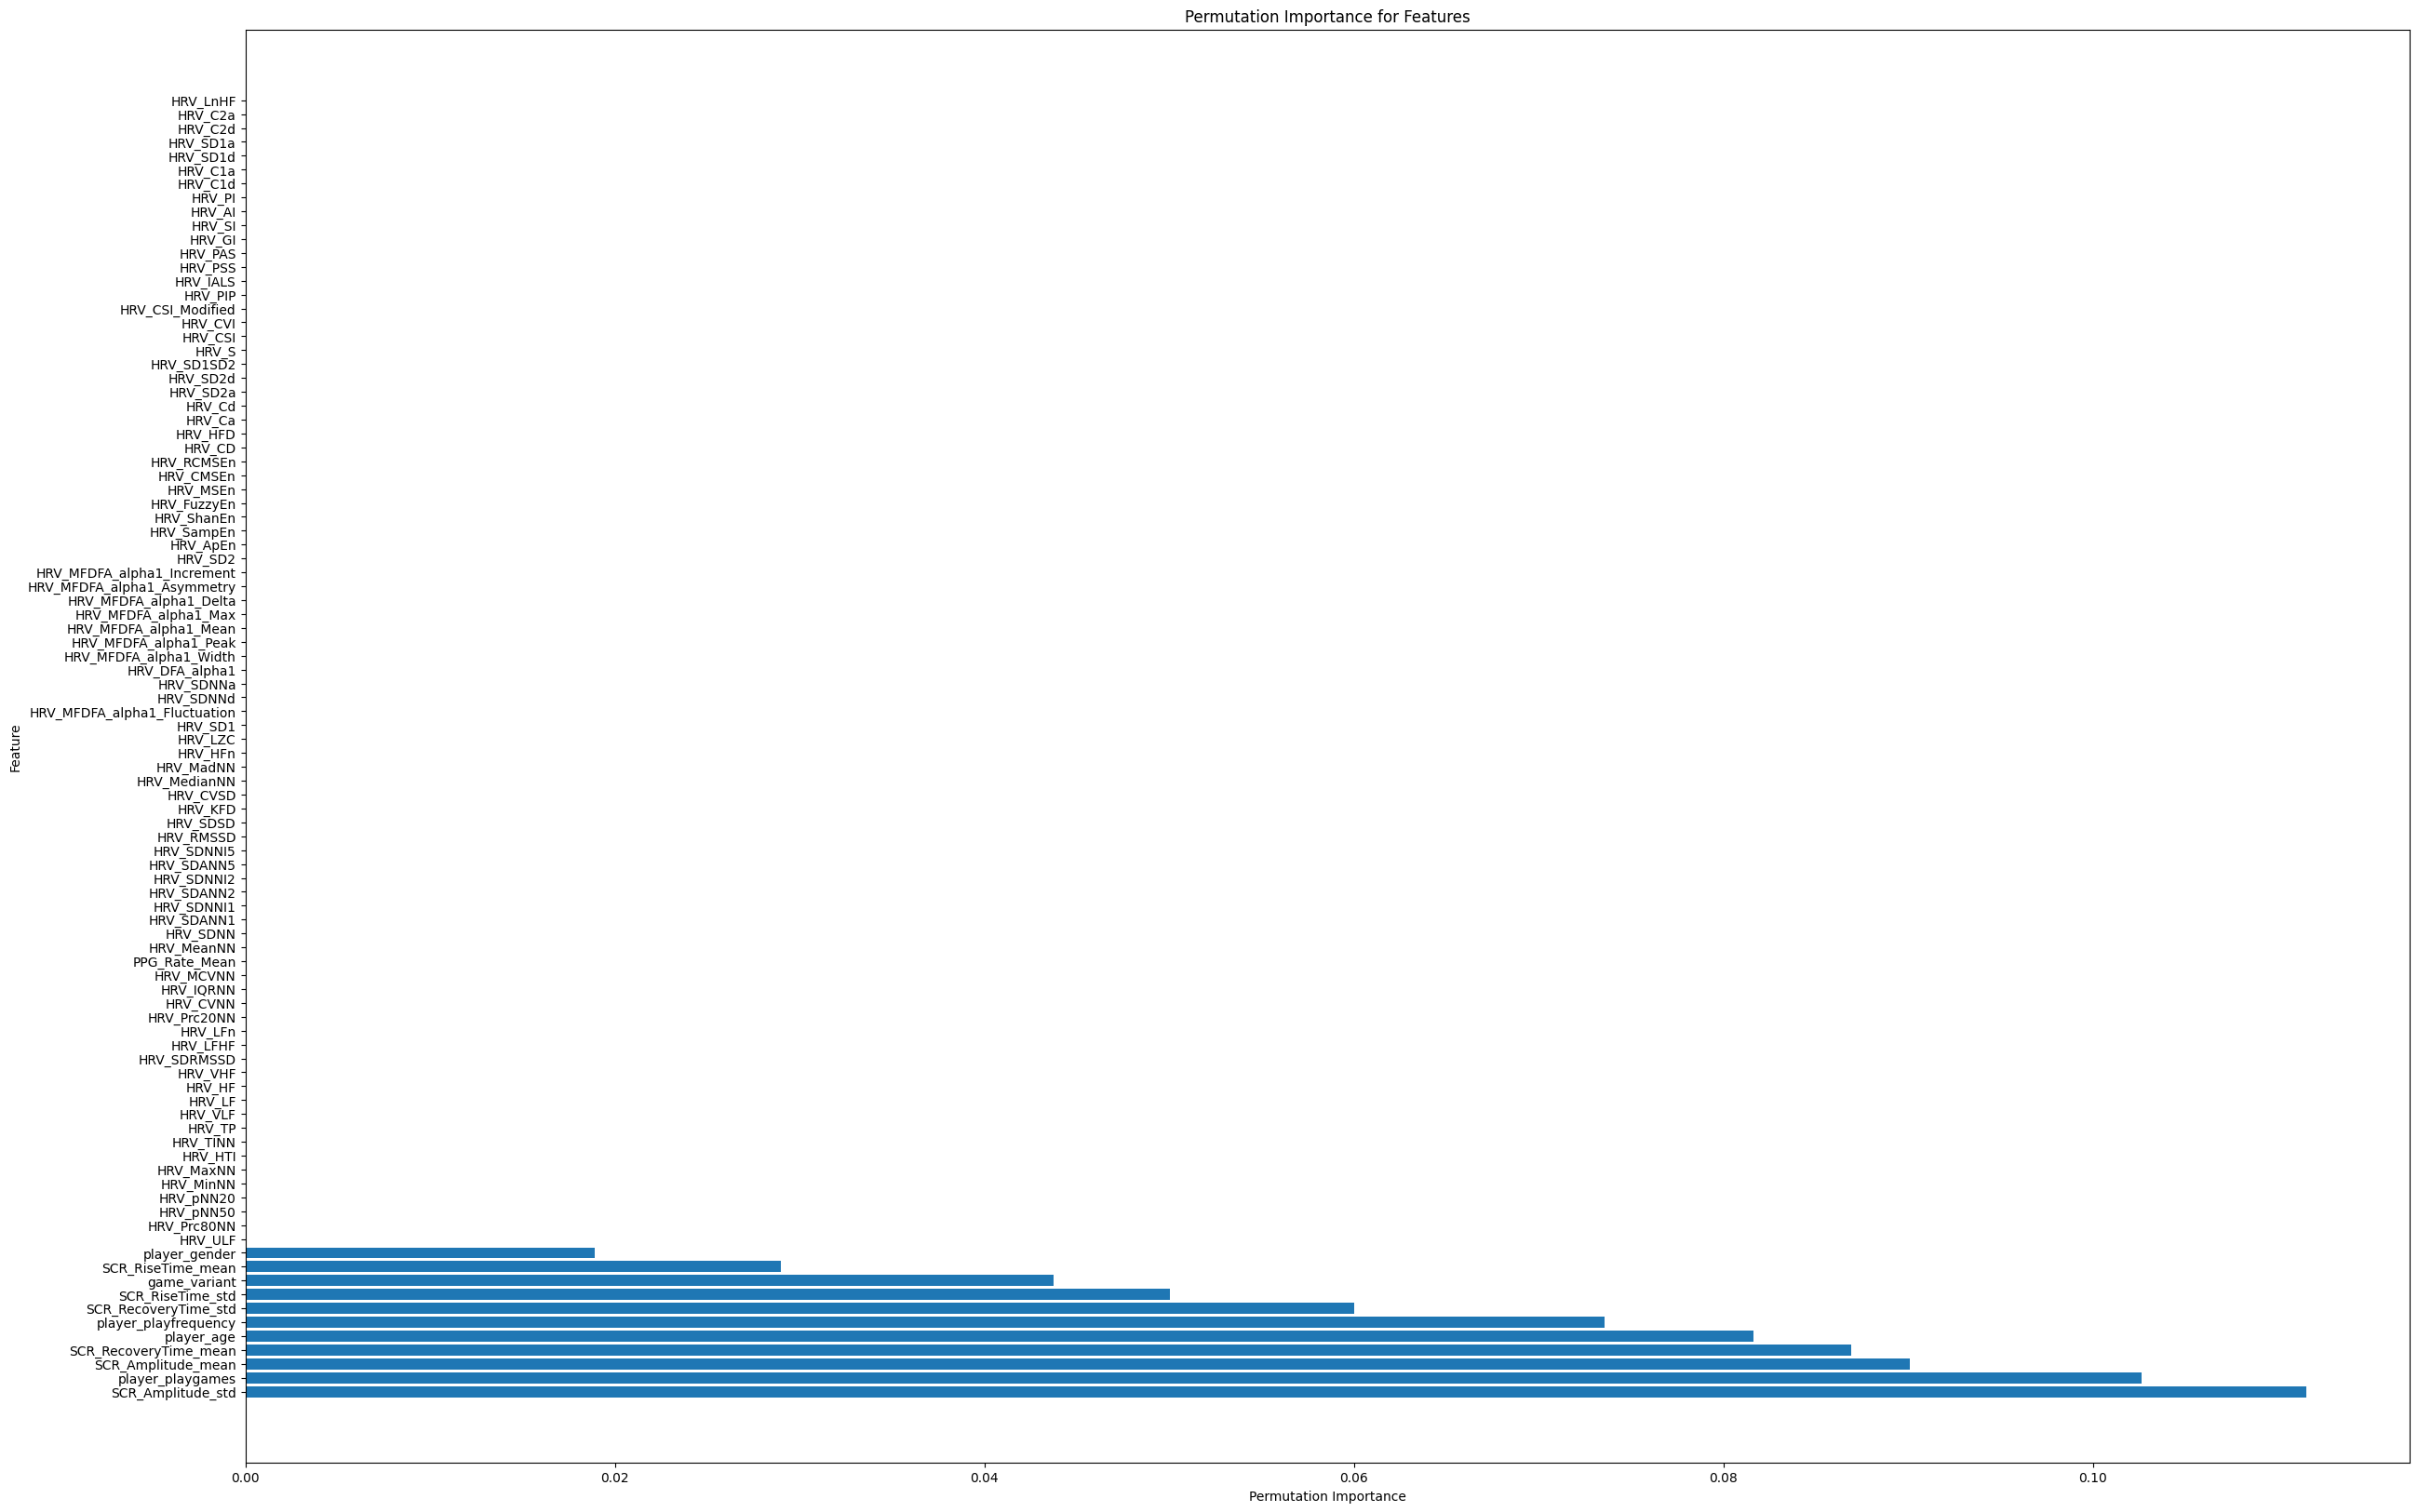

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Perform permutation importance
result = permutation_importance(regression_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importances and indices
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Convert feature_names to a regular Python list
feature_names_list = list(feature_names)

# Plot feature importances
plt.figure(figsize=(30, 20))
plt.barh(range(X_test.shape[1]), importances[indices], align="center")

yticks_spacing = 1.5  # Adjust the spacing factor
plt.yticks(range(X_test.shape[1]), [feature_names_list[i] for i in indices])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")

plt.title("Permutation Importance for Features")
plt.show()


In [ ]:
model_explainable = shap.TreeExplainer(regression_model, data=X)
shap_values = model_explainable.shap_values(X, Y)

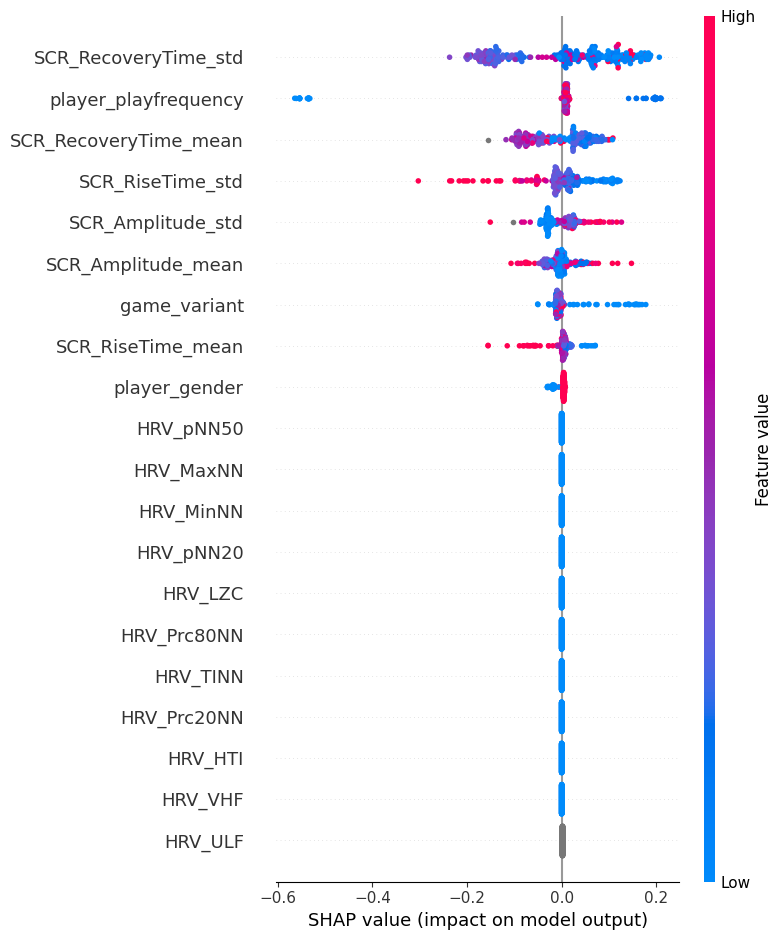

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

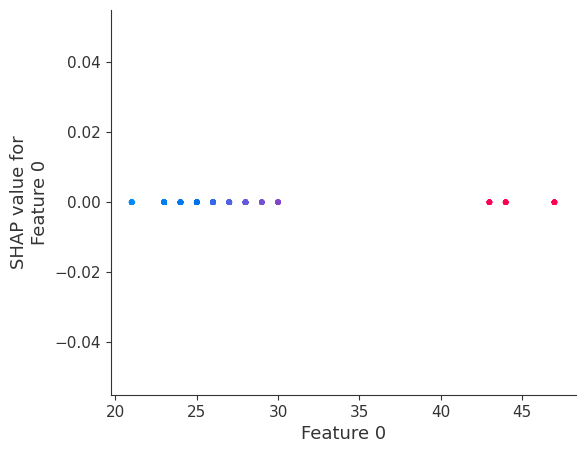

In [ ]:
shap.dependence_plot(0, shap_values, X)

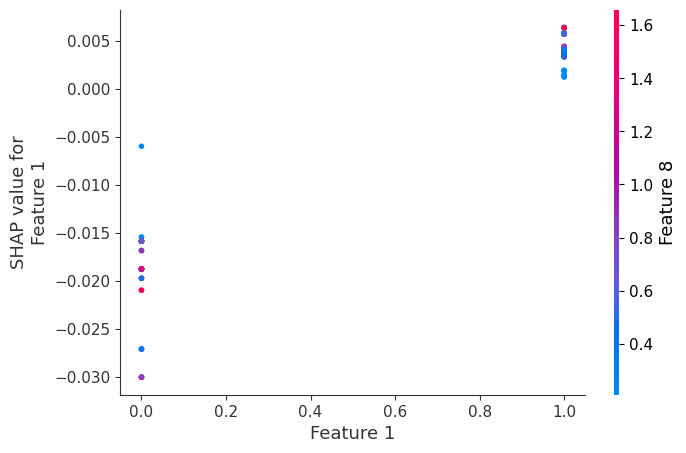

In [ ]:
shap.dependence_plot(1, shap_values, X)

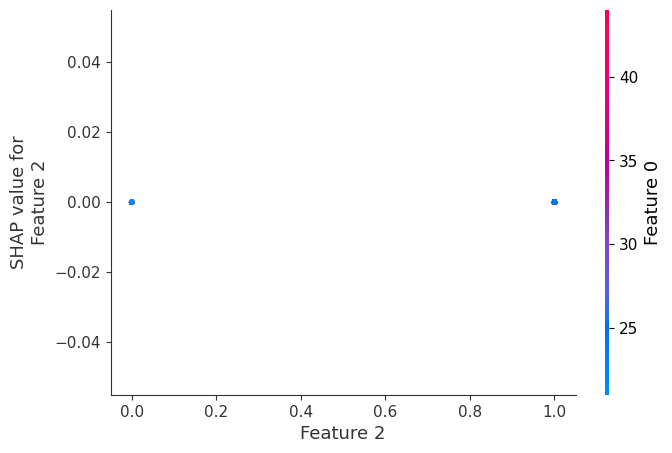

In [ ]:
shap.dependence_plot(2, shap_values, X)

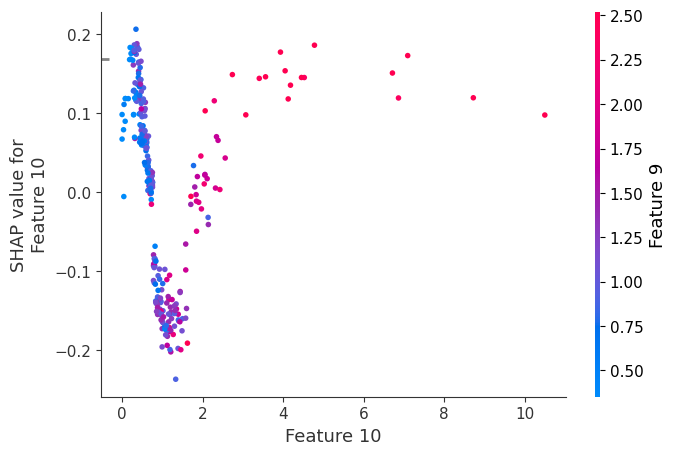

In [ ]:
shap.dependence_plot(10, shap_values, X)

In [ ]:
# How to improve the results?
# There are many modalities: game information, player information, and physiological information
# Which modality is more useful and which is less useful?
# Can the results be improved if the useless information are removed?